In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
import os
#from sklearn.model_selection import KFold
from radam import *
from csvlogger import *
from mish_activation import *
import warnings
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")

fastai.__version__

'1.0.61'

In [2]:
torch.cuda.get_device_name(0)

'GeForce RTX 2060'

In [3]:
# # grad acc

# class AccumulateOptimWrapper(OptimWrapper):
#     def step(self):           pass
#     def zero_grad(self):      pass
#     def real_step(self):      super().step()
#     def real_zero_grad(self): super().zero_grad()
        
# def acc_create_opt(self, lr:Floats, wd:Floats=0.):
#         "Create optimizer with `lr` learning rate and `wd` weight decay."
#         self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
#                                          wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
# Learner.create_opt = acc_create_opt 

# @dataclass
# class AccumulateStep(LearnerCallback):
#     """
#     Does accumlated step every nth step by accumulating gradients
#     """
#     def __init__(self, learn:Learner, n_step:int = 1):
#         super().__init__(learn)
#         self.n_step = n_step
        
#     def on_train_begin(self, **kwargs):
#         "check if loss is reduction"
#         if self.loss_func.reduction == "mean":
#              print("For better gradients consider 'reduction=sum'")
                
#     def on_epoch_begin(self, **kwargs):
#         "init samples and batches, change optimizer"
#         self.acc_batches = 0
        
#     def on_batch_begin(self, last_input, last_target, **kwargs):
#         "accumulate samples and batches"
#         self.acc_batches += 1
        
#     def on_backward_end(self, **kwargs):
#         "step if number of desired batches accumulated, reset samples"
#         if (self.acc_batches % self.n_step) == self.n_step - 1:
#             for p in (self.learn.model.parameters()):
#                 if p.requires_grad: p.grad.div_(self.acc_batches)
    
#             self.learn.opt.real_step()
#             self.learn.opt.real_zero_grad()
#             self.acc_batches = 0
    
#     def on_epoch_end(self, **kwargs):
#         "step the rest of the accumulated grads"
#         if self.acc_batches > 0:
#             for p in (self.learn.model.parameters()):
#                 if p.requires_grad: p.grad.div_(self.acc_batches)
#             self.learn.opt.real_step()
#             self.learn.opt.real_zero_grad()
#             self.acc_batches = 0

In [4]:
sz = 128
bs = 8
nfolds = 4
SEED = 2020
N = 12 #number of tiles per image
# gradient_acc:
n_acc = 8
n_groups = 32

TRAIN = '../data/processed/train_tiles_v0/'
LABELS = '../data/folds_workable.csv'

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Data

Use stratified KFold split.

In [7]:
df = pd.read_csv(LABELS).set_index('name')
files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))
list_img = df.index.tolist()
files = [fn for fn in files if fn in list_img]
df = df.loc[files]
df = df.reset_index()
df.head()

name data_provider  isup_grade gleason_score  \
0  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0   
1  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4   
2  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4   
3  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0   
4  003046e27c8ead3e3db155780dc5498e    karolinska           1           3+3   

   split  
0    3.0  
1    3.0  
2    2.0  
3    2.0  
4    3.0

Check [this kernel](https://www.kaggle.com/iafoss/panda-16x128x128-tiles) for image stats. Since I use zero padding and background corresponds to 255, I invert images as 255-img when load them. Therefore, the mean value is computed as '1 - val'.

In [8]:
mean = torch.tensor([1.0-0.80822448, 1.0-0.6134578, 1.0-0.74502575]) 
std = torch.tensor([0.41603894, 0.53319771,  0.43256397])  

The code below creates ImageItemList capable of loading multiple tiles of an image. It is specific for fast.ai, and pure Pytorch code would be much simpler.

In [9]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(1.0-x) #invert image for zero padding

class MImage(ItemBase):
    def __init__(self, imgs):
        self.obj, self.data = \
          (imgs), [(imgs[i].data - mean[...,None,None])/std[...,None,None] for i in range(len(imgs))]
    
    def apply_tfms(self, tfms,*args, **kwargs):
        for i in range(len(self.obj)):
            self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
            self.data[i] = (self.obj[i].data - mean[...,None,None])/std[...,None,None]
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {img.shape for img in self.obj}'
    def to_one(self):
        img = torch.stack(self.data,1)
        img = img.view(3,-1,N,sz,sz).permute(0,1,3,2,4).contiguous().view(3,-1,sz*N)
        return Image(1.0 - (mean[...,None,None]+img*std[...,None,None]))

class MImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        fn = Path(self.items[i])
        fnames = [Path(str(fn)+'_'+str(i)+'.png')for i in range(N)]
        imgs = [open_image(fname, convert_mode=self.convert_mode, after_open=self.after_open)
               for fname in fnames]
        return MImage(imgs)

    def reconstruct(self, t):
        return MImage([mean[...,None,None]+_t*std[...,None,None] for _t in t])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(300,50), **kwargs):
        rows = min(len(xs),8)
        fig, axs = plt.subplots(rows,1,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

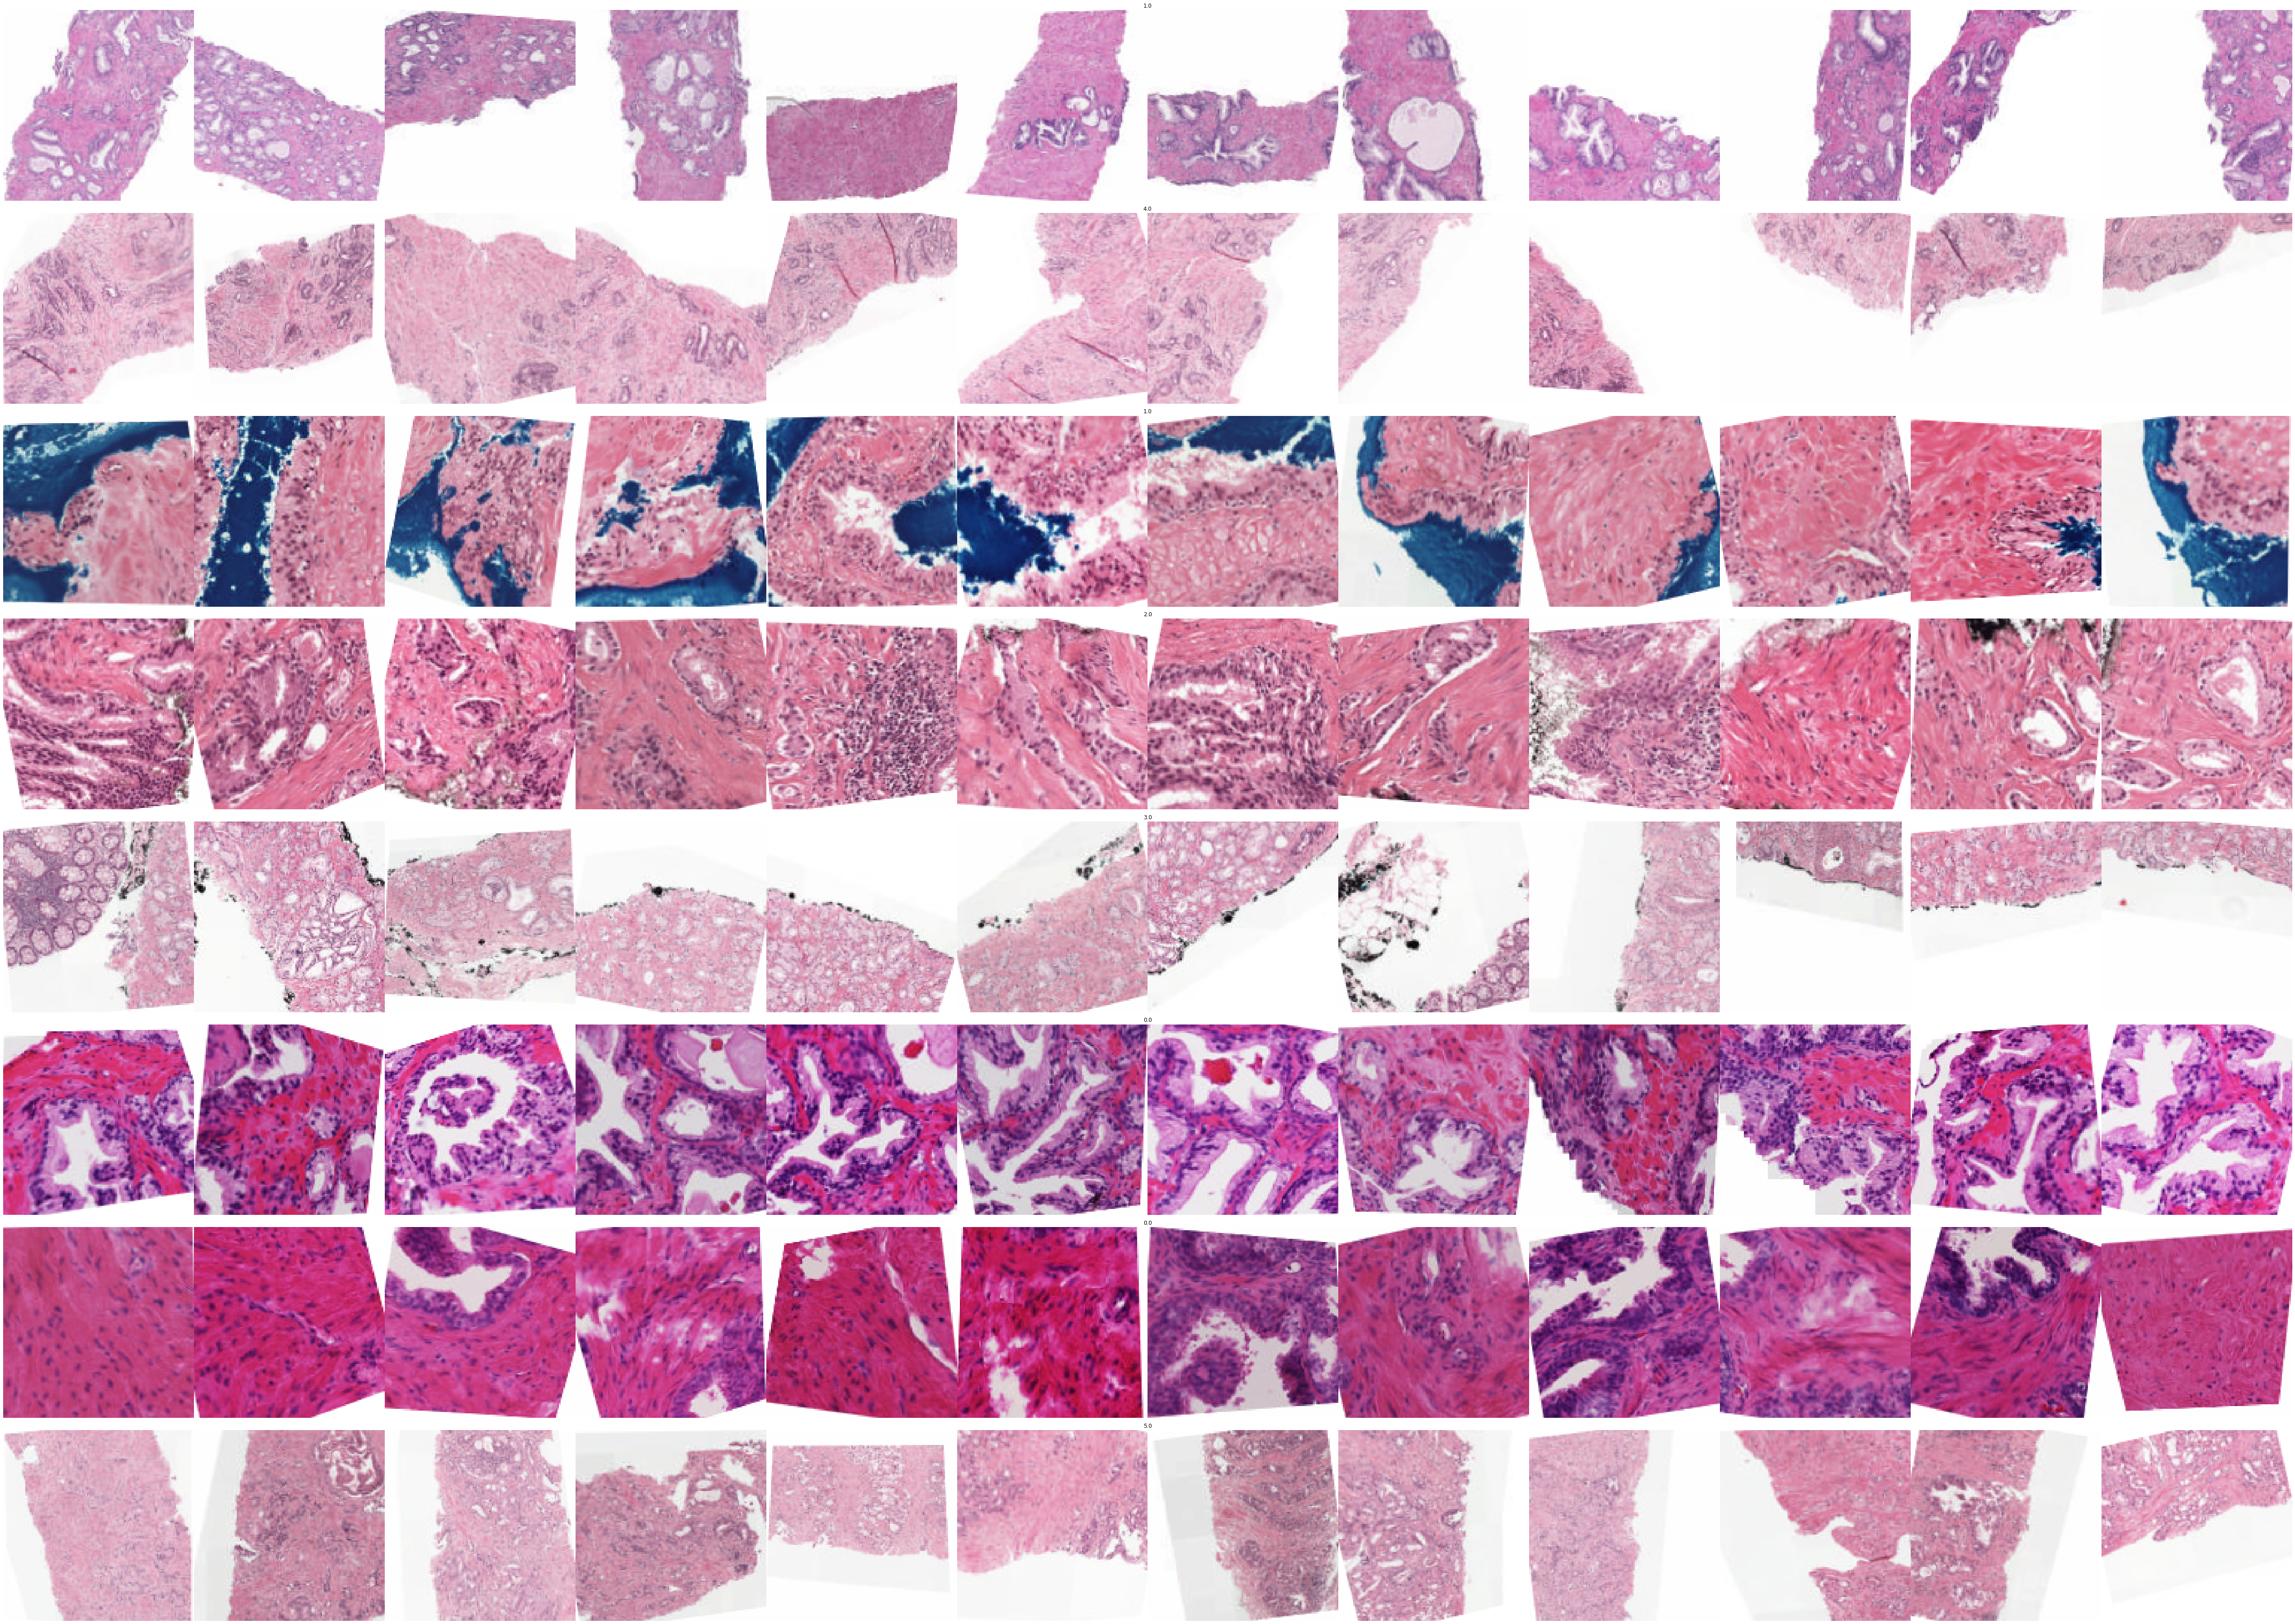

In [10]:
def get_data(fold=0):
    return (MImageItemList.from_df(df, path='.', folder=TRAIN, cols='name')
      .split_by_idx(df.index[df.split == fold].tolist())
      .label_from_df(cols=['isup_grade'], label_cls=FloatList)
      .transform(get_transforms(flip_vert=True,max_rotate=15),size=sz,padding_mode='zeros')
      .databunch(bs=bs,num_workers=8))

data = get_data(0)
data.show_batch()

# Model

The code below implements Concat Tile pooling idea. As a backbone I use [Semi-Weakly Supervised ImageNet pretrained ResNeXt50 model](https://github.com/facebookresearch/semi-supervised-ImageNet1K-models), which worked for me quite well in a number of previous competitions.

In [11]:
#ResNeXt-101 32x4d
#ResNeXt-101 32x8d
#ResNeXt-101 32x16d

class Model(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=1, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),Flatten(),nn.Linear(2*nc,512),
                            Mish(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512,n, bias=True))
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*n,shape[3])
        #x: bs x C x N*4 x 4
        x = self.head(x)
        return x

# Training

In [12]:
from fastai.callbacks import ReduceLROnPlateauCallback

In [13]:
fname = 'RNXT50_BP'

In [14]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    torch_yhat = torch.round(y_hat).cpu()
    predictions = [max(min(int(i), 5),0) for i in torch_yhat]
    return torch.tensor(cohen_kappa_score(predictions, y.cpu(), weights='quadratic'),device='cuda:0')

In [15]:
# #find LR
# fold=0
# data = get_data(fold)
# model = Model()
# learn = Learner(data, model, opt_func=Over9000, 
#             metrics=[quadratic_kappa]).to_fp16()
# learn.clip_grad = 1.0
# learn.split([model.head])
# learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot()

In [16]:
torch.cuda.empty_cache() 

In [ ]:
lr = 7e-4

OFF = pd.DataFrame()

for fold in range(1):
    data = get_data(fold)
    model = Model()
    learn = Learner(data, model, opt_func=Over9000, 
                metrics=[quadratic_kappa]).to_fp16()
    logger = CSVLogger(learn, f'log_{fname}_{fold}')
    learn.clip_grad = 1.0
    learn.split([model.head])
    learn.unfreeze()

    #16 epochs 
    learn.fit_one_cycle(50, max_lr=lr, div_factor=100, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name=f'model',monitor='valid_loss'),
                  ReduceLROnPlateauCallback(learn, patience=2),])
                  #AccumulateStep(learn,n_acc)])
    torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')
#     learn.load(f'/media/maria/e23b3738-8a18-4a79-8991-eb5e39b99bb0/Prostate/resnext50_32x4d/{fname}_{fold}');
    
#     #Save file with the probabilities of each fold
#     preds,y,losses = learn.get_preds(with_loss=True)
    
#     predictions = pd.DataFrame(preds.numpy())
#     predictions.columns = ['predictions']
    
#     predictions_fold = df.loc[df['split'] == fold]
#     predictions_fold.reset_index(inplace=True)
    
#     predictions_fold = pd.concat([predictions_fold, predictions], axis=1)
    
#     OFF = pd.concat([OFF, predictions_fold], axis =0)

Using cache found in /home/benjamin/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Better model found at epoch 0 with valid_loss value: 4.3562188148498535.
Better model found at epoch 1 with valid_loss value: 2.9640235900878906.
Better model found at epoch 2 with valid_loss value: 1.7911767959594727.
Better model found at epoch 4 with valid_loss value: 1.510783076286316.
Better model found at epoch 6 with valid_loss value: 1.5011249780654907.
Better model found at epoch 12 with valid_loss value: 1.438014030456543.
Better model found at epoch 13 with valid_loss value: 1.3869565725326538.
Better model found at epoch 14 with valid_loss value: 1.3419994115829468.
Better model found at epoch 17 with valid_loss value: 1.3257033824920654.
Better model found at epoch 20 with valid_loss value: 1.3092304468154907.
Better model found at epoch 28 with valid_loss value: 1.2998218536376953.
Better model found at epoch 30 with valid_loss value: 1.2502257823944092.
Better model found at epoch 36 with valid_loss value: 1.132003903388977.


# Same with gradient accumulation

In [ ]:
# grad acc

class AccumulateOptimWrapper(OptimWrapper):
    def step(self):           pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr:Floats, wd:Floats=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = acc_create_opt 

@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step
        
    def on_train_begin(self, **kwargs):
        "check if loss is reduction"
        if self.loss_func.reduction == "mean":
             print("For better gradients consider 'reduction=sum'")
                
    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
lr = 7e-4

OFF = pd.DataFrame()

for fold in range(1):
    data = get_data(fold)
    model = Model()
    learn = Learner(data, model, opt_func=Over9000, 
                metrics=[quadratic_kappa]).to_fp16()
    logger = CSVLogger(learn, f'log_{fname}_{fold}')
    learn.clip_grad = 1.0
    learn.split([model.head])
    learn.unfreeze()

    #16 epochs 
    learn.fit_one_cycle(50, max_lr=lr, div_factor=100, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name=f'model',monitor='valid_loss'),
                  ReduceLROnPlateauCallback(learn, patience=2),
                  AccumulateStep(learn,n_acc)])
    torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')

In [14]:
# resuls for bs=12, grad_acc=8 with otsu tiles 

Using cache found in /home/benjamin/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


For better gradients consider 'reduction=sum'


Better model found at epoch 0 with valid_loss value: 8.295421600341797.
Better model found at epoch 1 with valid_loss value: 4.5342512130737305.
Better model found at epoch 2 with valid_loss value: 2.2236013412475586.
Epoch 5: reducing lr to 0.00019298117572246745
Better model found at epoch 7 with valid_loss value: 1.7283190488815308.
Epoch 10: reducing lr to 0.0001770574428389478
Epoch 13: reducing lr to 0.00016374980369689463
Better model found at epoch 16 with valid_loss value: 1.707984447479248.
Better model found at epoch 18 with valid_loss value: 1.6363104581832886.
Epoch 21: reducing lr to 0.00011874760667834402
Better model found at epoch 22 with valid_loss value: 1.5934712886810303.
Better model found at epoch 24 with valid_loss value: 1.473313808441162.
Better model found at epoch 25 with valid_loss value: 1.353162407875061.
Epoch 28: reducing lr to 7.514039925160399e-05
Epoch 31: reducing lr to 5.743086687388868e-05
Epoch 34: reducing lr to 4.122937080224304e-05
Epoch 37: r

Using cache found in /home/benjamin/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


For better gradients consider 'reduction=sum'


Better model found at epoch 0 with valid_loss value: 3.425016164779663.
Better model found at epoch 1 with valid_loss value: 3.0940611362457275.


KeyboardInterrupt: 

In [16]:
from sklearn.metrics import cohen_kappa_score

In [17]:
OFF.head()

index                          image_id data_provider  isup_grade  \
0      0  0005f7aaab2800f6170c399693a96917    karolinska           0   
1      2  0018ae58b01bdadc8e347995b69f99aa       radboud           4   
2      3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4   
3      8  003a91841da04a5a31f808fb5c21538a    karolinska           1   
4     10  00412139e6b04d1e1cee8421f38f6e90    karolinska           0   

  gleason_score  split  predictions  
0           0+0      0     0.031799  
1           4+4      0     5.398438  
2           4+4      0     5.328125  
3           3+3      0     0.869141  
4           0+0      0     0.599609

In [18]:
predictions = [max(min(int(i), 5),0) for i in OFF['predictions'].round()]

In [19]:
#CV

#save off
OFF.to_csv('OOF_resnext50_32x4d_ssl.csv', index=False)

In [20]:
OFF['predicted_class'] = predictions

In [21]:
cohen_kappa_score(OFF['predicted_class'], OFF['isup_grade'], weights='quadratic')

0.8213583896708624

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
confusion_matrix(OFF['predicted_class'], OFF['isup_grade'])

array([[2114,  292,   34,   10,   28,   10],
       [ 558, 1598,  330,   98,   69,   33],
       [ 140,  548,  487,  202,  137,   52],
       [  44,  151,  367,  367,  234,  140],
       [  11,   24,  119,  478,  493,  407],
       [   5,    3,    4,   71,  284,  573]])

In [24]:
OFF.to_csv('OOF_resnext50_32x4d_ssl.csv', index=False)

In [25]:
OFF= pd.read_csv('OOF_resnext50_32x4d_ssl.csv')

In [26]:
len(df.index[df.split == 0].tolist()) + len(df.index[df.split == 1].tolist()) + len(df.index[df.split == 2].tolist()) + len(df.index[df.split == 3].tolist())

10515